In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas_ta as ta
from arch import arch_model
import numpy as np
from ib_insync import *
from collections import deque
from enum import Enum
import datetime
import logging
import math
util.startLoop()

In [2]:
"""logging parameters"""
today = datetime.datetime.today().date()
logging.basicConfig(level = logging.INFO,
                   filename = 'algo_log_'+str(today)+'_.log',
                   filemode='w')


In [3]:

contract_dict = {'Stock':Stock, 'Crypto':Crypto}

class Algo():
    def __init__(self, client, addr, port, client_id):
        self.client = client
        self.addr = addr
        self.port = port
        self.client_id = client_id
        
        self.client.connect(addr, port, client_id)
        
    def SetPaperBalances(self):
        self.USD_balance = 1000
        self.BTC_balance = 0
        
        print('USD balance: {}'.format(self.USD_balance))
        print('BTC balance: {}'.format(self.BTC_balance))
    
    def GetContract(self, contract_type, ticker, exchange, currency):
        return contract_dict[contract_type](ticker, exchange, currency)
    
    def GetHistoricalData(self, contract, duration='1 D', bar_size='1 hour'):
        bars = ib.reqHistoricalData(contract=contract, endDateTime='', durationStr=duration,
                                    barSizeSetting=bar_size, whatToShow='MIDPOINT', useRTH=True)
        return bars
    
    def BuildEMA(self, slow_period, fast_period):
        """using deques instead of dataframes"""
        self.slow_ema = deque(maxlen=slow_period)
        self.fast_ema = deque(maxlen=fast_period)
        
        """need to employ scanner to pull in data"""
        
           
    def GetDMI(self, df):
        df_adx = ta.adx(high=df['high'], low=df['low'], close=df['close'])
        df['ADX'] = df_adx['ADX_14']
        df['DMN'] = df_adx['DMN_14']
        df['DMP'] = df_adx['DMP_14']
        df['DM_diff'] = df['DMP'] > df['DMN']
        return df
        
    
    
    def GetMovingAverages(self, df, low, high, plot=True):
#         print('length:', len(df))
        df_MA = df.copy()
        if len(df) < high:
            return
#         display('in mov avg fn', df_MA)
        
        df_MA[str(low)+'_average'] = df.close.rolling(low).mean()
        df_MA[str(high)+'_average'] = df.close.rolling(high).mean()
#         df_MA.dropna(inplace=True)
        df_MA['MA_diff'] = df_MA[str(high)+'_average'] > df_MA[str(low)+'_average']
        
        if plot:
            df_MA['close'].plot(legend=True)
            df_MA[str(low)+'_average'].plot(legend=True)
            df_MA[str(high)+'_average'].plot(legend=True)
        
#         display('end of mov avg', df_MA)
        return df_MA
    
    
    def PlacePaperOrder(self, order_type, price=None, quantity=None, date=None):
        print('placing order:', order_type)

        if order_type=='sell':
            print(date)
            print('{} @ {}'.format(order_type, price))
            self.BTC_balance -= quantity
            self.USD_balance += quantity * price
            

        elif order_type=='buy':
            print(date)
            print('{} @ {}'.format(order_type, price))
            self.BTC_balance += quantity
            self.USD_balance -= quantity * price

        else:
            return 


        print('USD balance: {}'.format(self.USD_balance))
        print('BTC balance: {}'.format(self.BTC_balance))
        account_balance = self.USD_balance + self.BTC_balance * price
        print('Account balance: {}\n'.format(account_balance))       

    def RunDMI(self, df, ADX_MIN=20):
        for count, row in enumerate(df.iterrows()):
            if count==0:
                sentiment = row[1]['DM_diff']
            else:
                if (row[1]['ADX'] >= ADX_MIN):
                    if row[1]['DM_diff'] == sentiment:
                        self.PlacePaperOrder('no change')
                    else:
                        if row[1]['DM_diff']:
                            self.PlacePaperOrder('buy',row[1]['close'],1, row[1]['date'])
                        else:
                            self.PlacePaperOrder('sell', row[1]['close'],1, row[1]['date'])
                    sentiment = row[1]['DM_diff']
                else: continue                                     
                        
    
    def RunStrategy(self, df):   

        for count, row in enumerate(df.iterrows()):
            if count==0:
                sentiment = row[1]['MA_diff']
            else:
                if row[1]['MA_diff'] == sentiment:
                    self.PlacePaperOrder('no change')
                else:
                    if row[1]['MA_diff']:
                        self.PlacePaperOrder('sell',row[1]['close'],1)
                    else:
                        self.PlacePaperOrder('buy', row[1]['close'],1)
                    sentiment = row[1]['MA_diff']


def Main(client_id):
    
    ib = IB()
    algo = Algo(ib, '127.0.0.1', 7497, client_id=client_id)
    
    contract = algo.GetContract('Crypto','BTC', 'PAXOS', 'USD')
    
    bars = algo.GetHistoricalData(contract, '180 D', '1 day')
    
    df = util.df(bars)
    
    algo.SetPaperBalances()
    
#     df_MA =  algo.GetMovingAverages(df, 10, 30, True)
    df_DMI = algo.GetDMI(df)
    
#     algo.RunStrategy(df_MA)
    algo.RunDMI(df_DMI)
    
    print('USD balance: {}'.format(algo.USD_balance))
    print('BTC balance: {}'.format(algo.BTC_balance))

    account_value = algo.USD_balance + algo.BTC_balance * bars[-1].close
    print('Account value: {}'.format(account_value))
    
    

In [7]:
class Account():
    def __init__(self, USD_balance: int, BTC_balance: int, BTC_price: float = None):
        self.USD_balance = USD_balance
        self.BTC_balance = BTC_balance
        self.BTC_price = BTC_price                 
        self.df_account = pd.DataFrame(columns=['Date', 'USD', 'BTC', 'Account Value', 'BTC Px'])
        
    def __call__(self):
        return self.returnBalance()
        
    def __repr__(self):
        return 'USD balance: '+ str(self.USD_balance) + '\nBTC balance: ' + str(self.BTC_balance) + '\nAccount Value: '+str(self.USD_balance + self.BTC_balance * self.BTC_price) + '\nBTC Price:' + str(self.BTC_price)
        
        
    def updateBTCPrice(self, BTC_price: float):
        self.BTC_price = BTC_price
        
    def closePosition(self):
        self.BTC_balance = 0
        self.USD_balance -= self.BTC_balance * self.BTC_price
    
    def tradeBTC(self, signal: Signal, quantity: int, date: datetime): #-> order:
        logging.info(str(signal), str(quantity)+' @ ', str(self.BTC_price))
        
        direction = 1 if signal==Signal.BUY else -1
        
        self.BTC_balance += direction * quantity
        self.USD_balance -= direction * quantity * self.BTC_price
        
        order_type = 'BUY' if signal==Signal.BUY else 'SELL'
        
        order = LimitOrder(order_type, quantity, round(self.BTC_price, 0),
                           tif='GTC')
        return order 
        
#         self.updateBalance([date, self.USD_balance, self.BTC_balance, self.total])
                
    def updateBalance(self, date):
        total = self.USD_balance + self.BTC_balance * self.BTC_price
        self.df_account.loc[len(self.df_account.index)] = [date, self.USD_balance,
                                                          self.BTC_balance, total, self.BTC_price]       
        
    def returnBalance(self):
        return self.df_account
    
    def plotBalance(self):
        self.df_account.plot(x='Date', y=['Account Value'])
        
        

In [8]:
"""real time updates"""

from collections import deque
import pandas as pd


Sentiment = Enum('Sentiment','BEAR NEUTRAL BULL')
Signal = Enum('Signal','BUY SELL')

strategy_dict = dict()

def AddStrategy(strategy_fn):
    strategy_dict[strategy_fn.__name__] = strategy_fn
    return strategy_fn
  
def LogFunctionCall(fn):
    logging.info(fn.__name__+' called')
    return fn

def PrintFunction(fn):
    print(fn)
    print(fn.__code__.co_varnames)
    return fn
    


class Strategy():
    def __init__(self, account: Account, ib, client_id: int, paper_trading: bool = True):
        self.client_id = client_id
        self.ib = ib     
        self.algo = Algo(ib, '127.0.0.1', 7497, client_id=self.client_id)
        self.algo.SetPaperBalances()
        self.contract = Crypto('BTC', exchange='PAXOS', currency='USD')
        self.account = account
        self.paper_trading=paper_trading
        self.sentiment = dict()
        self.signal = dict()
        self.trades = list()


    
    def onBarUpdate(self, bars, newBar):
        if newBar:
#             print(bars)
            print('on bar update', bars[-1])
            self.strategy_params['close'] = bars[-1].close 
            self.strategy(**self.strategy_params)


    #         self.low_deque.append(bars[-1].close)
    #         self.high_deque.append(bars[-1].close)
    #         self.account.updateBTCPrice(BTC_price=bars[-1].close)
    #         self.MovingAverage(self.low_deque, self.high_deque, bars[-1].close)
            self.SignalProcess(self.strategy.__name__, date=bars[-1].time)
    
#     def MovingAverage(self, low_deque, high_deque, closing_value):
  
    @AddStrategy
    @LogFunctionCall
    def MovingAverage(self, low, high, close):

        
        if not (hasattr(self, "low_deque") and hasattr(self, "high_deque")):
            low_deque_len, high_deque_len = low, high
            self.low_deque = deque(maxlen=low_deque_len)
            self.high_deque = deque(maxlen=high_deque_len)              

        self.low_deque.append(close)
        self.high_deque.append(close)
        self.account.updateBTCPrice(BTC_price=close)        
        
        if len(self.high_deque) < self.high_deque.maxlen:
            return
        low_avg = sum(self.low_deque)/len(self.low_deque)
        high_avg = sum(self.high_deque)/len(self.high_deque)

        if low_avg < high_avg:
            current_sentiment_MA = Sentiment.BEAR
        elif low_avg > high_avg:
            current_sentiment_MA = Sentiment.BULL
        else:
            current_sentiment_MA = Sentiment.NEUTRAL
        
        print('low avg:', low_avg, 'high avg:', high_avg)
        
        if self.sentiment.get('MovingAverage') is None:
            print('1st change')
            self.sentiment['MovingAverage'] = current_sentiment_MA
            return

        if self.sentiment['MovingAverage'] != current_sentiment_MA:
            print('previous sentiment:', self.sentiment.get('MovingAverage'))
            print('current sentiment:', current_sentiment_MA)
            
            if current_sentiment_MA == Sentiment.BEAR:
                self.signal['MovingAverage'] = Signal.SELL               

            elif current_sentiment_MA == Sentiment.BULL:
                self.signal['MovingAverage'] = Signal.BUY            
            print(self.signal['MovingAverage'])
        else:
            print('no trades')
                              
        self.sentiment['MovingAverage'] = current_sentiment_MA
        print('current sentiment: ', current_sentiment_MA)
        
#         previous sentiment: Sentiment.BULL
# current sentiment: Sentiment.BEAR
# Signal.SELL
# current sentiment:  Sentiment.BEAR
# signals: []
        
        
    @LogFunctionCall
    @PrintFunction
    def SignalProcess(self, *signals, date):        
        signal_list = [values for keys,values in self.signal.items() if keys in signals]
        
        if len(set(signal_list))==1 and signal_list[0] is not None: #i.e. all signals are the same
            print(date)
            signal = signal_list[0]
            print(str(signal) + ' @ ' + str(self.account.BTC_price))
            order = self.account.tradeBTC(signal=signal, quantity=1, date=date)
            
            if not self.paper_trading:
                self.trades.append(self.ib.placeOrder(self.contract, order))
            
            self.ClearSignals(*signals)                
        
        self.account.updateBalance(date=date)
        print(self.account)
    
    def ClearSignals(self, *signals):
        for s in signals:
            self.signal[s]=None                  

    def SetStrategy(self, strategy, **kwargs):
#         self.strategy_name=strategy
        self.strategy = strategy_dict[strategy]
        self.strategy_params = kwargs
        self.strategy_params['self'] = self
        
        
    
    def RunStrategy(self):       
       
#         low, high = 5, 10
#         self.low_deque = deque(maxlen=low)
#         self.high_deque = deque(maxlen=high)

        bars = ib.reqRealTimeBars(contract=self.contract,
                                  barSize=5,
                                  whatToShow='MIDPOINT',
                                 useRTH=False)
        bars.updateEvent += self.onBarUpdate


        self.ib.sleep(100)
        self.ib.cancelRealTimeBars(bars)        
    
        
    def Backtest(self, duration='1 D', barSize='5 secs'):
        self.paper_trading = True
        bars = ib.reqHistoricalData(
            self.contract, endDateTime='', durationStr=duration,
            barSizeSetting=barSize, whatToShow='MIDPOINT', useRTH=True)
        
        df = util.df(bars)
        
        low, high = 5, 10
        low_deque = deque(maxlen=low)
        high_deque = deque(maxlen=high)
        for row in df.itertuples(name='bar', index=False):            
            low_deque.append(row.close)
            high_deque.append(row.close)
            self.account.updateBTCPrice(BTC_price=row.close)
            self.MovingAverage(low_deque, high_deque, row.close)
            self.SignalProcess('MA', date=row.date)
    


    



<function Strategy.SignalProcess at 0x00000239E454D310>
('self', 'date', 'signals', 'signal_list', 'signal', 'order')


In [8]:
ib = IB()
account = Account(USD_balance=1000, BTC_balance=0)
S = Strategy(account, ib, 1, paper_trading=True)

S.SetStrategy('MovingAverage',low=2,high=3)
S.RunStrategy()

    
# s.Backtest(duration='240 s',
#           barSize='5 secs')
# account.plotBalance()

USD balance: 1000
BTC balance: 0
on bar update RealTimeBar(time=datetime.datetime(2022, 11, 29, 3, 55, 10, tzinfo=datetime.timezone.utc), endTime=-1, open_=16275.625, high=16275.625, low=16275.625, close=16275.625, volume=-1.0, wap=-1.0, count=-1)
USD balance: 1000
BTC balance: 0
Account Value: 1000.0
BTC Price:16275.625
on bar update RealTimeBar(time=datetime.datetime(2022, 11, 29, 3, 55, 15, tzinfo=datetime.timezone.utc), endTime=-1, open_=16275.625, high=16276.125, low=16275.625, close=16276.125, volume=-1.0, wap=-1.0, count=-1)
USD balance: 1000
BTC balance: 0
Account Value: 1000.0
BTC Price:16276.125
on bar update RealTimeBar(time=datetime.datetime(2022, 11, 29, 3, 55, 20, tzinfo=datetime.timezone.utc), endTime=-1, open_=16276.125, high=16279.875, low=16276.125, close=16279.625, volume=-1.0, wap=-1.0, count=-1)
low avg: 16277.875 high avg: 16277.125
1st change
USD balance: 1000
BTC balance: 0
Account Value: 1000.0
BTC Price:16279.625
on bar update RealTimeBar(time=datetime.datetim

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\kushwaha\Anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\kushwaha\Anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\kushwaha\Anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\kushwaha\Anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\kushwaha\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\kushwaha\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\kushwaha\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\kushwaha\Anaconda3\lib\site-pac

on bar update RealTimeBar(time=datetime.datetime(2022, 11, 29, 3, 56, 30, tzinfo=datetime.timezone.utc), endTime=-1, open_=16276.75, high=16278.625, low=16276.25, close=16278.625, volume=-1.0, wap=-1.0, count=-1)
low avg: 16277.6875 high avg: 16278.333333333334
no trades
current sentiment:  Sentiment.BEAR
USD balance: 17276.75
BTC balance: -1
Account Value: 998.125
BTC Price:16278.625
on bar update RealTimeBar(time=datetime.datetime(2022, 11, 29, 3, 56, 35, tzinfo=datetime.timezone.utc), endTime=-1, open_=16278.625, high=16278.625, low=16278.625, close=16278.625, volume=-1.0, wap=-1.0, count=-1)
low avg: 16278.625 high avg: 16278.0
previous sentiment: Sentiment.BEAR
current sentiment: Sentiment.BULL
Signal.BUY
current sentiment:  Sentiment.BULL
2022-11-29 03:56:35+00:00
Signal.BUY @ 16278.625
USD balance: 998.125
BTC balance: 0
Account Value: 998.125
BTC Price:16278.625


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\kushwaha\Anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\kushwaha\Anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\kushwaha\Anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\kushwaha\Anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\kushwaha\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\kushwaha\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\kushwaha\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\kushwaha\Anaconda3\lib\site-pac

on bar update RealTimeBar(time=datetime.datetime(2022, 11, 29, 3, 56, 40, tzinfo=datetime.timezone.utc), endTime=-1, open_=16278.625, high=16278.625, low=16278.625, close=16278.625, volume=-1.0, wap=-1.0, count=-1)
low avg: 16278.625 high avg: 16278.625
previous sentiment: Sentiment.BULL
current sentiment: Sentiment.NEUTRAL
None
current sentiment:  Sentiment.NEUTRAL
USD balance: 998.125
BTC balance: 0
Account Value: 998.125
BTC Price:16278.625
on bar update RealTimeBar(time=datetime.datetime(2022, 11, 29, 3, 56, 45, tzinfo=datetime.timezone.utc), endTime=-1, open_=16278.625, high=16278.625, low=16278.625, close=16278.625, volume=-1.0, wap=-1.0, count=-1)
low avg: 16278.625 high avg: 16278.625
no trades
current sentiment:  Sentiment.NEUTRAL
USD balance: 998.125
BTC balance: 0
Account Value: 998.125
BTC Price:16278.625
on bar update RealTimeBar(time=datetime.datetime(2022, 11, 29, 3, 56, 50, tzinfo=datetime.timezone.utc), endTime=-1, open_=16278.625, high=16278.625, low=16278.625, close=

In [20]:
ib.disconnect()

In [99]:
"""calculate hurst exponent
H < 0.5: mean-reverting
H = 0.5: GBM
H > 0.5: trending
"""
"""https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e#:~:text=To%20calculate%20the%20Hurst%20exponent,versus%20the%20mentioned%20standard%20deviations.
"""

# BTC - short duration - 5 min barsize setting over 7D  - appears mean reverting; half-life was 100 bars
# SPY - short duration - 5 mins over 7d - appears trending 

ib = IB()
ib.connect('127.0.0.1', 7497, 7)
# contract = Crypto('BTC', exchange='PAXOS', currency='USD')
contract = Stock('SPY', 'SMART', currency='USD')
bars = ib.reqHistoricalData(contract=contract, endDateTime='', durationStr='365 D',
                                    barSizeSetting='8 hours', whatToShow='MIDPOINT', useRTH=False)

In [100]:
df = pd.DataFrame({'close':[i.close for i in bars], 'date':[i.date for i in bars]})
time_series = np.array([i.close for i in bars])
df



,close,date
0,426.295,2021-06-25 04:00:00
1,426.885,2021-06-25 12:00:00
2,426.535,2021-06-28 04:00:00
3,427.205,2021-06-28 12:00:00
4,427.995,2021-06-29 04:00:00
...,...,...
829,406.035,2022-12-02 11:00:00
830,405.945,2022-12-02 19:00:00
831,403.360,2022-12-05 04:00:00
832,400.240,2022-12-05 11:00:00


In [17]:
"""get returns"""
df['returns'] = df['close'].pct_change()
returns = np.array(df['returns'].dropna())
returns[0:5]

array([-0.01363374, -0.01218101,  0.04000757,  0.04269911,  0.0109376 ])

In [94]:
def GetHurst(time_series, max_lag=5):
    lags = range(2, max_lag)
    
    #variances of lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    
    #hurst exponent is the slope of the log plot
    regression = np.polyfit(x=np.log(lags), y=np.log(tau), deg=1)
    
    return regression[0]
    
    

In [101]:
max_lags = [5, 10, 30, 100, 300]
for i in max_lags:
    print(GetHurst(time_series=time_series, max_lag=i))

0.5010967434731647
0.4991682130560413
0.48189360065690673
0.432548549816401
0.32952678096131766


<AxesSubplot:>

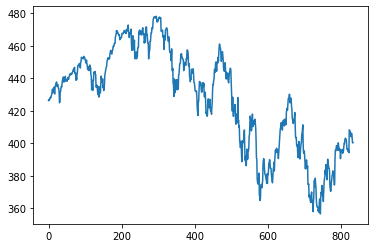

In [103]:
df['close'].plot()

In [18]:
max_lags = [5, 10, 30]
for i in max_lags:
    print(GetHurst(time_series=returns, max_lag=i))

-0.03173854596913254
-0.012352595490179237
-0.006478070055894387


In [47]:
"""testing GBM, trending, and mean reverting"""
sample_size = 1000
scalar = 100

np.random.seed(123)
df_test_data = pd.DataFrame(data={"mean_rev": np.log(np.random.randn(sample_size) + scalar),
                        "gbm": np.log(np.cumsum(np.random.randn(sample_size)) + scalar),
                        "trending": np.log(np.cumsum(np.random.randn(sample_size) + 1) + scalar)})

In [104]:
"""calculate half life"""
lag = 5
# df = pd.DataFrame({'close': df_test_data['mean_rev']})


In [105]:
df['lag'] = df['close'].shift(periods=lag)


In [106]:
df.dropna(inplace = True)
# df.head(10)
# df.tail(20)
X = df['lag']
Y = df['close'] - df['lag']
X = sm.add_constant(X)

In [107]:
model = sm.OLS(Y,X)
results = model.fit()
results.params
print(results.t_test([1,0]))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            12.6648      3.726      3.399      0.001       5.351      19.979


In [108]:
results.pvalues

const    0.000709
lag      0.000596
dtype: float64

In [109]:
slope = results.params['lag']

In [110]:
half_life = -math.log(2)/slope
half_life

23.115004958980904

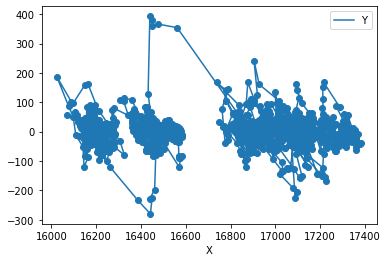

In [90]:
df_ols = pd.DataFrame({'Y': Y, 'X': X['lag']})
df_ols.plot(x='X',y='Y')
plt.scatter(df_ols['X'], df_ols['Y'])

In [ ]:
"""program sequence
1) pick markets - SPY, BTC, commodities, rates, etc
2) determine if trending, mean-reverting, or gbm
 - should focus on longer time intervals to reduce the amount of trades
3) determine indicators for each regime
a) if mean-reverting, calculate half-life for look back window
   - mean-reverting signals?
b) if trending, trending signals ?
 
-

"""